# Assess income level predictions on adult census data

This notebook demonstrates the use of the `responsibleai` API to assess a model trained on census data. It walks through the API calls necessary to create a widget with model analysis insights, then guides a visual analysis of the model.

* [Launch Responsible AI Toolbox](#Launch-Responsible-AI-Toolbox)
    * [Train a Model](#Train-a-Model)
    * [Create Model and Data Insights](#Create-Model-and-Data-Insights)
* [Assess Your Model](#Assess-Your-Model)
    * [Aggregate Analysis](#Aggregate-Analysis)
    * [Individual Analysis](#Individual-Analysis)

## Launch Responsible AI Toolbox

The following section examines the code necessary to create datasets and a model. It then generates insights using the `responsibleai` API that can be visually analyzed.

### Train a Model
*The following section can be skipped. It loads a dataset and trains a model for illustrative purposes.*

In [ ]:
import sklearn
import zipfile

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import pandas as pd
from lightgbm import LGBMClassifier

First, load the census dataset and specify the different types of features. Then, clean the target feature values to include only 0 and 1.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

def clean_data(X, y, target_feature):
    features = X.columns.values.tolist()
    classes = y[target_feature].unique().tolist()
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }
    num_pipe = Pipeline([
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])
    X = feat_pipe.fit_transform(X)
    print(pipe_cfg['cat_cols'])
    return X, feat_pipe, features, classes

outdirname = 'erroranalysis.12.3.20'
try:
    from urllib import urlretrieve
except ImportError:
    from urllib.request import urlretrieve
zipfilename = outdirname + '.zip'
urlretrieve('https://publictestdatasets.blob.core.windows.net/data/' + zipfilename, zipfilename)
with zipfile.ZipFile(zipfilename, 'r') as unzip:
    unzip.extractall('.')

target_feature = 'income'
categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race', 'gender', 'native-country']


train_data = pd.read_csv('adult-train.csv')
test_data = pd.read_csv('adult-test.csv')


X_train_original, y_train = split_label(train_data, target_feature)
X_test_original, y_test = split_label(test_data, target_feature)


X_train, feat_pipe, features, classes = clean_data(X_train_original, y_train, target_feature)
y_train = y_train[target_feature].to_numpy()

X_test = feat_pipe.transform(X_test_original)
y_test = y_test[target_feature].to_numpy()

train_data[target_feature] = y_train
test_data[target_feature] = y_test

test_data_sample = test_data.sample(n=500, random_state=5)
train_data_sample = train_data.sample(n=8000, random_state=5)

Train a LightGBM classifier on the training data.

In [ ]:
clf = LGBMClassifier(n_estimators=5)
model = clf.fit(X_train, y_train)

### Create Model and Data Insights

In [ ]:
from raiwidgets import ModelAnalysisDashboard
from responsibleai import ModelAnalysis

To use Responsible AI Toolbox, initialize a ModelAnalysis object upon which different components can be loaded.

ModelAnalysis accepts the model, the full dataset, the test dataset, the target feature string, the task type string, and a list of strings of categorical feature names as its arguments.

In [ ]:
dashboard_pipeline = Pipeline(steps=[('preprocess', feat_pipe), ('model', model)])

model_analysis = ModelAnalysis(dashboard_pipeline, train_data_sample, test_data_sample, target_feature, 'classification',
                               categorical_features=categorical_features)

Add the components of the toolbox that are focused on model assessment.

In [ ]:
# Interpretability
model_analysis.explainer.add()
# Error Analysis
model_analysis.error_analysis.add()
# Counterfactuals: accepts total number of counterfactuals to generate, the label that they should have, and a list of 
                # strings of categorical feature names
model_analysis.counterfactual.add(total_CFs=10, desired_class='opposite')

Once all the desired components have been loaded, compute insights on the test set.

In [ ]:
model_analysis.compute()

Finally, visualize and explore the model insights. Use the resulting widget or follow the link to view this in a new tab.

In [ ]:
ModelAnalysisDashboard(model_analysis)

## Assess Your Model

### Aggregate Analysis

The Error Analysis component is displayed at the top of the dashboard widget. To visualize how error is broken down across cohorts, use the tree map view to understand how it filters through the nodes.

![Error Analysis tree map with "Marital Status == 2," "Capital Gain <= 1287.5," "Capital Loss <= 1494.5" path selected](./img/classification-assessment-1.png)

Over 40% of the error in this model is concentrated in datapoints of people who are married, have higher education and minimal capital gain. 

Let's see what else we can discover about this cohort.

First, save the cohort by clicking "Save as a new cohort" on the right side panel of the Error Analysis component.

![Cohort creation sidebar and tree map cohort creation popup](./img/classification-assessment-2.png)

To switch to this cohort for analysis, click "Switch global cohort" and select the recently saved cohort from the dropdown.

![Popup with dropdown to shift cohort from "All data" to "Married, Low Capital Loss/Gain" accompanied by cohort statistics](./img/classification-assessment-3.png)

The Model Overview component allows the comparison of statistics across multiple saved cohorts.

The diagram indicates that the model is misclassifying datapoints of married individuals with low capital gains and high education as lower income (false negative).

![Bar chart of classification outcomes (true negative, true positive, false negative, false positive) compared across cohorts](./img/classification-assessment-4.png)

Looking at the ground truth statistics of the overall data and the erroneous cohort, we realize there are opposite patterns in terms of high income representation in ground truth. While the overall data is representing more individuals with actual income of <= 50K, the married individuals with low capital gains and high education represent more individuals with actual income of > 50K. Given the small size of the dataset and this reverse pattern, the model makes more mistakes in predicting high income individuals. One action item is to collect a lot more data in both cohorts and retrain the model.


![image-3.png](./img/classification-assessment-5.png)

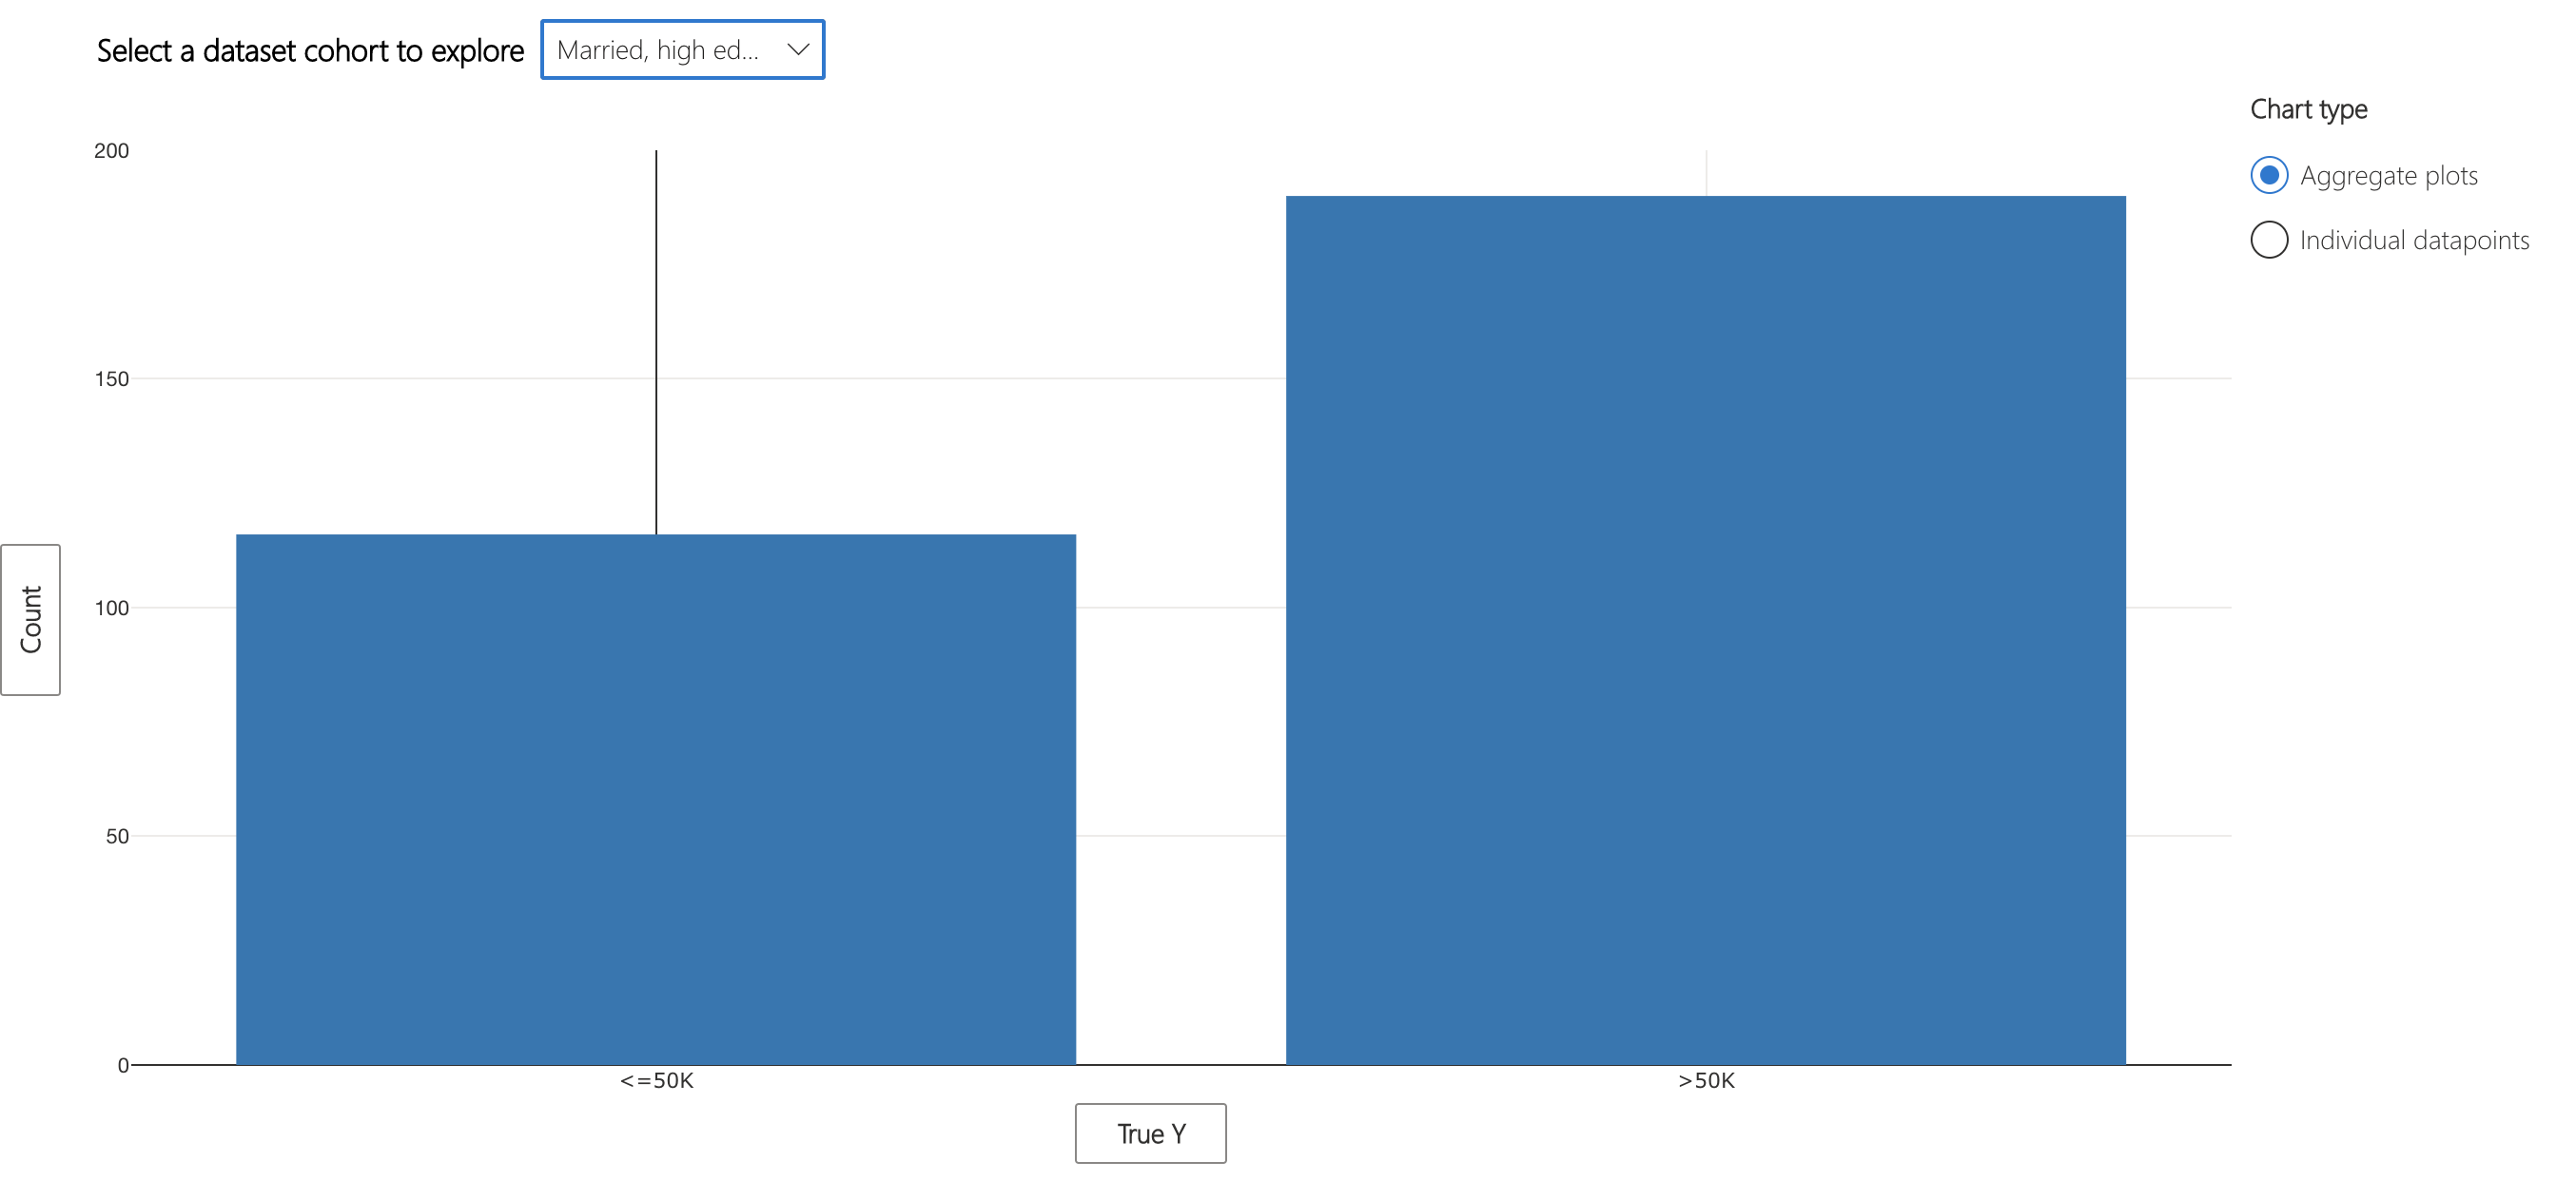

The Interpretability component displays feature importances for model predictions at an individual and aggregate level. The plot below indicates that the `marital-status` attribute influence model predictions the most on average.

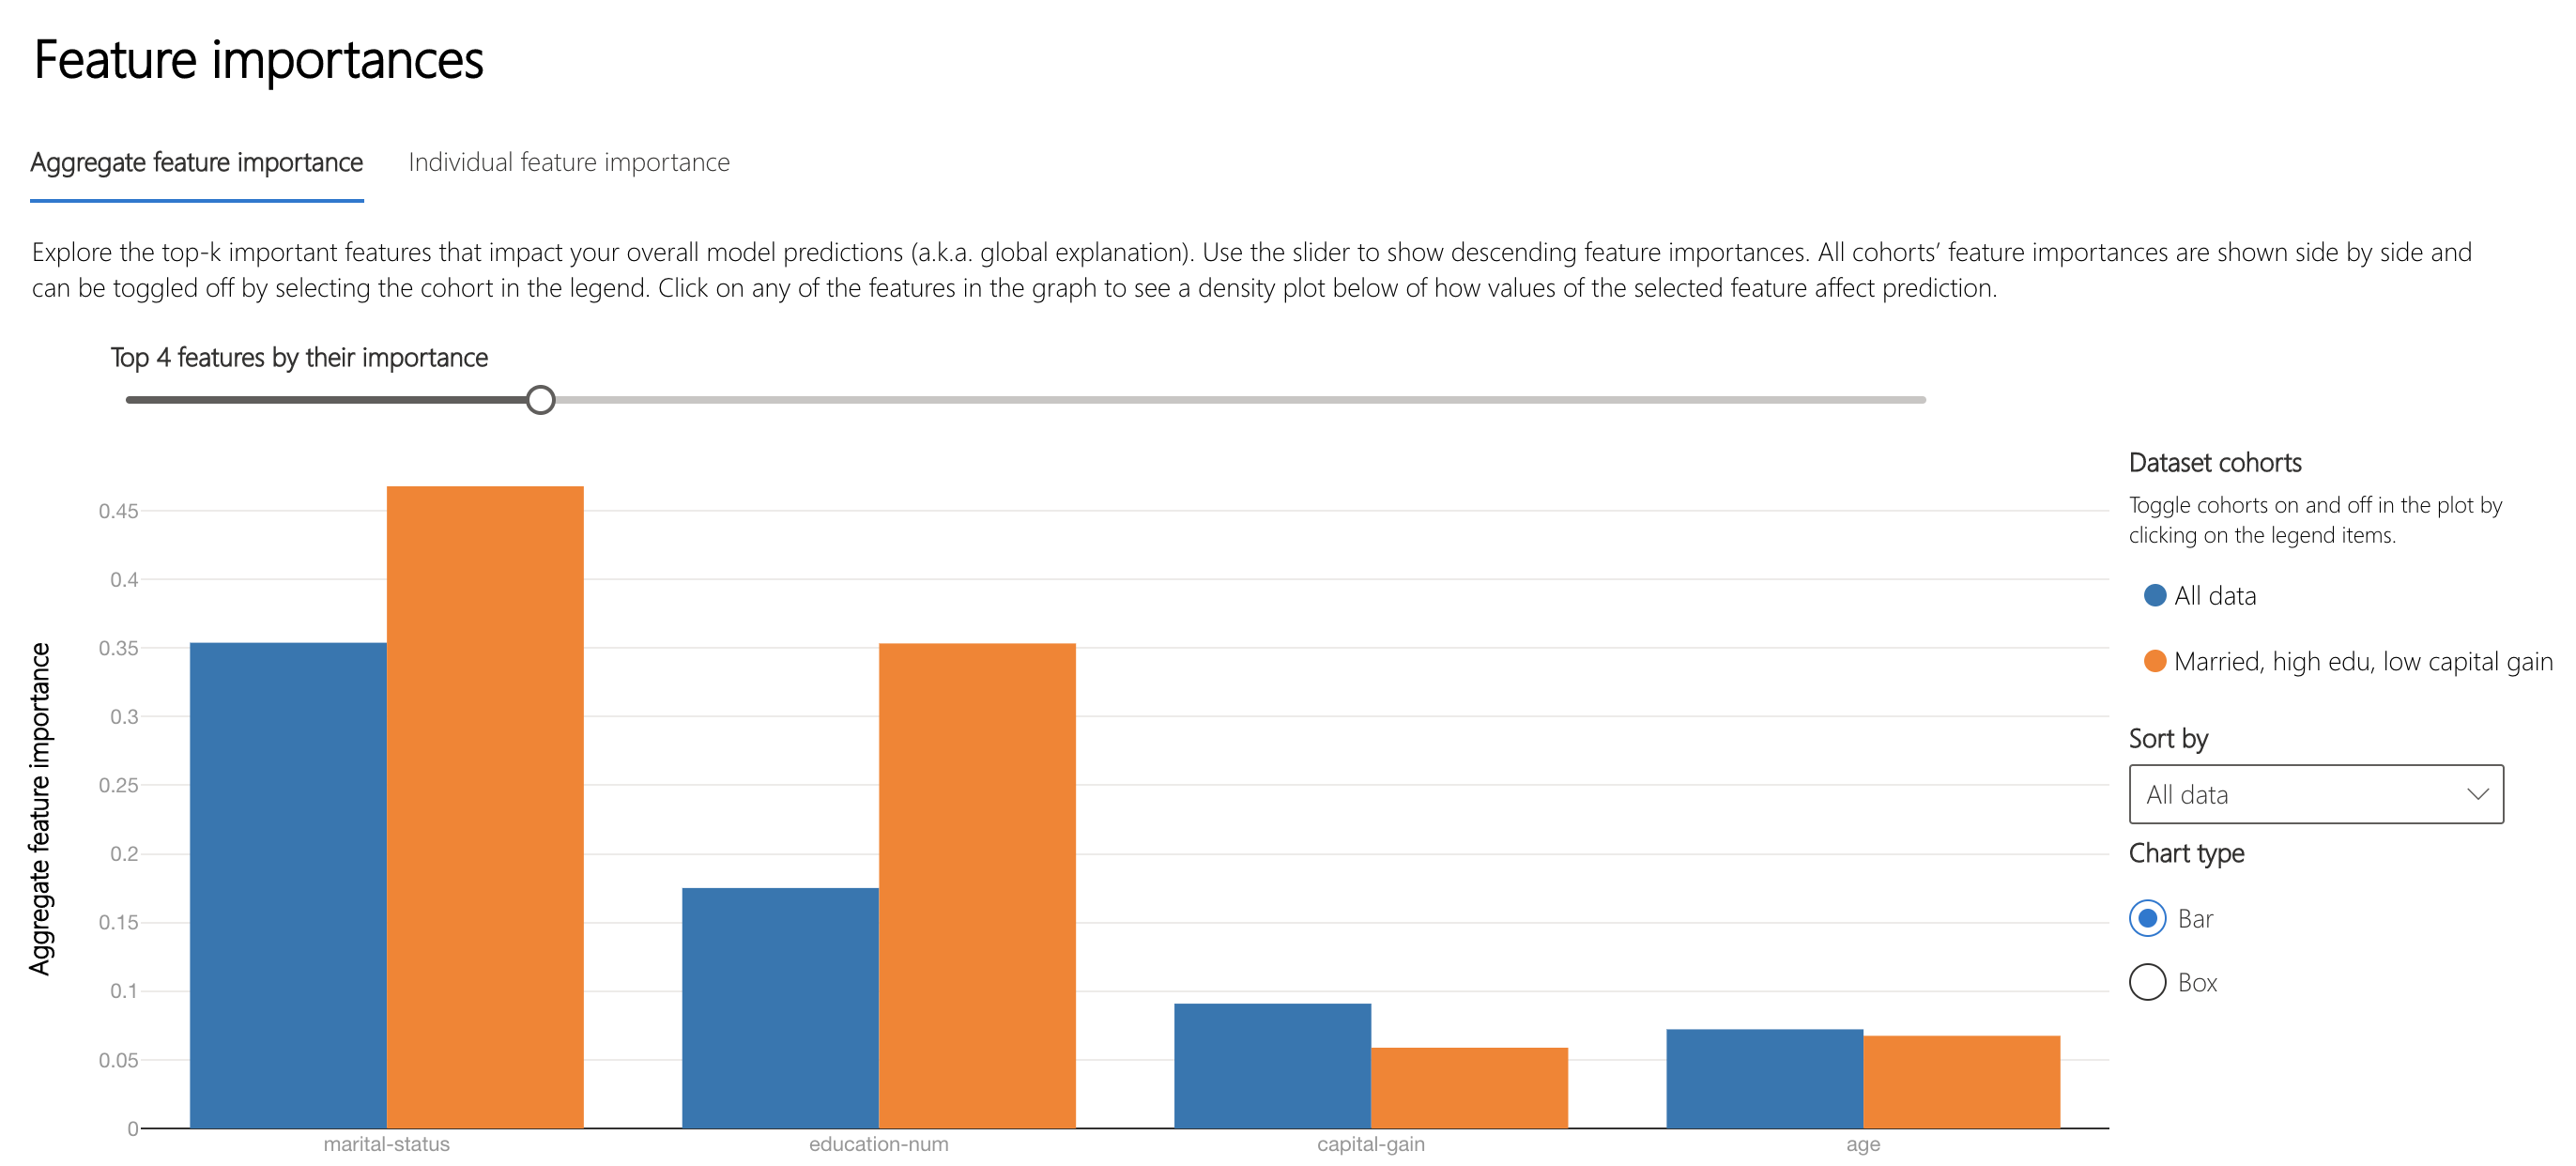

The lower half of this tab specifies how marita status affects model prediction. Being a husband or wife (married-civ-spouse) is more likely to pull the prediction away from <=50k, possibly because couples have a higher cumulative income.

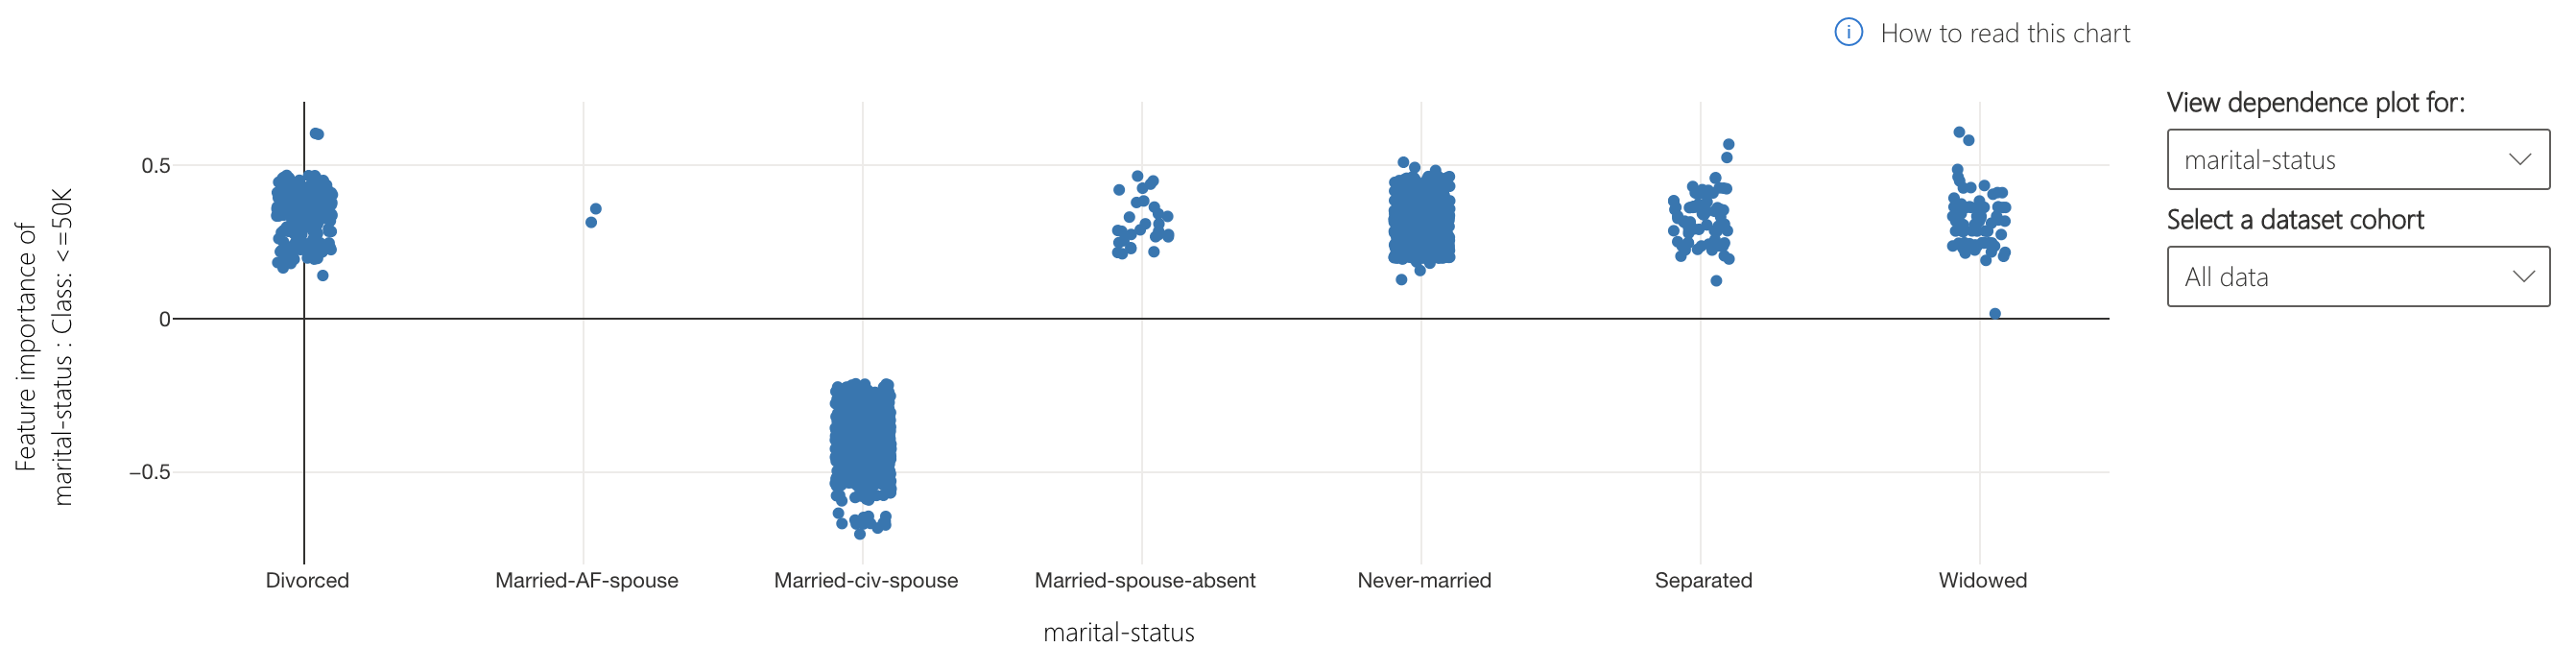

### Individual Analysis

Let's revisit Data Explorer. In the "Individual datapoints" view, we can see the prediction probabilities of each point. Point 510 is one that was just above the threshold to be classified as income of > 50K.

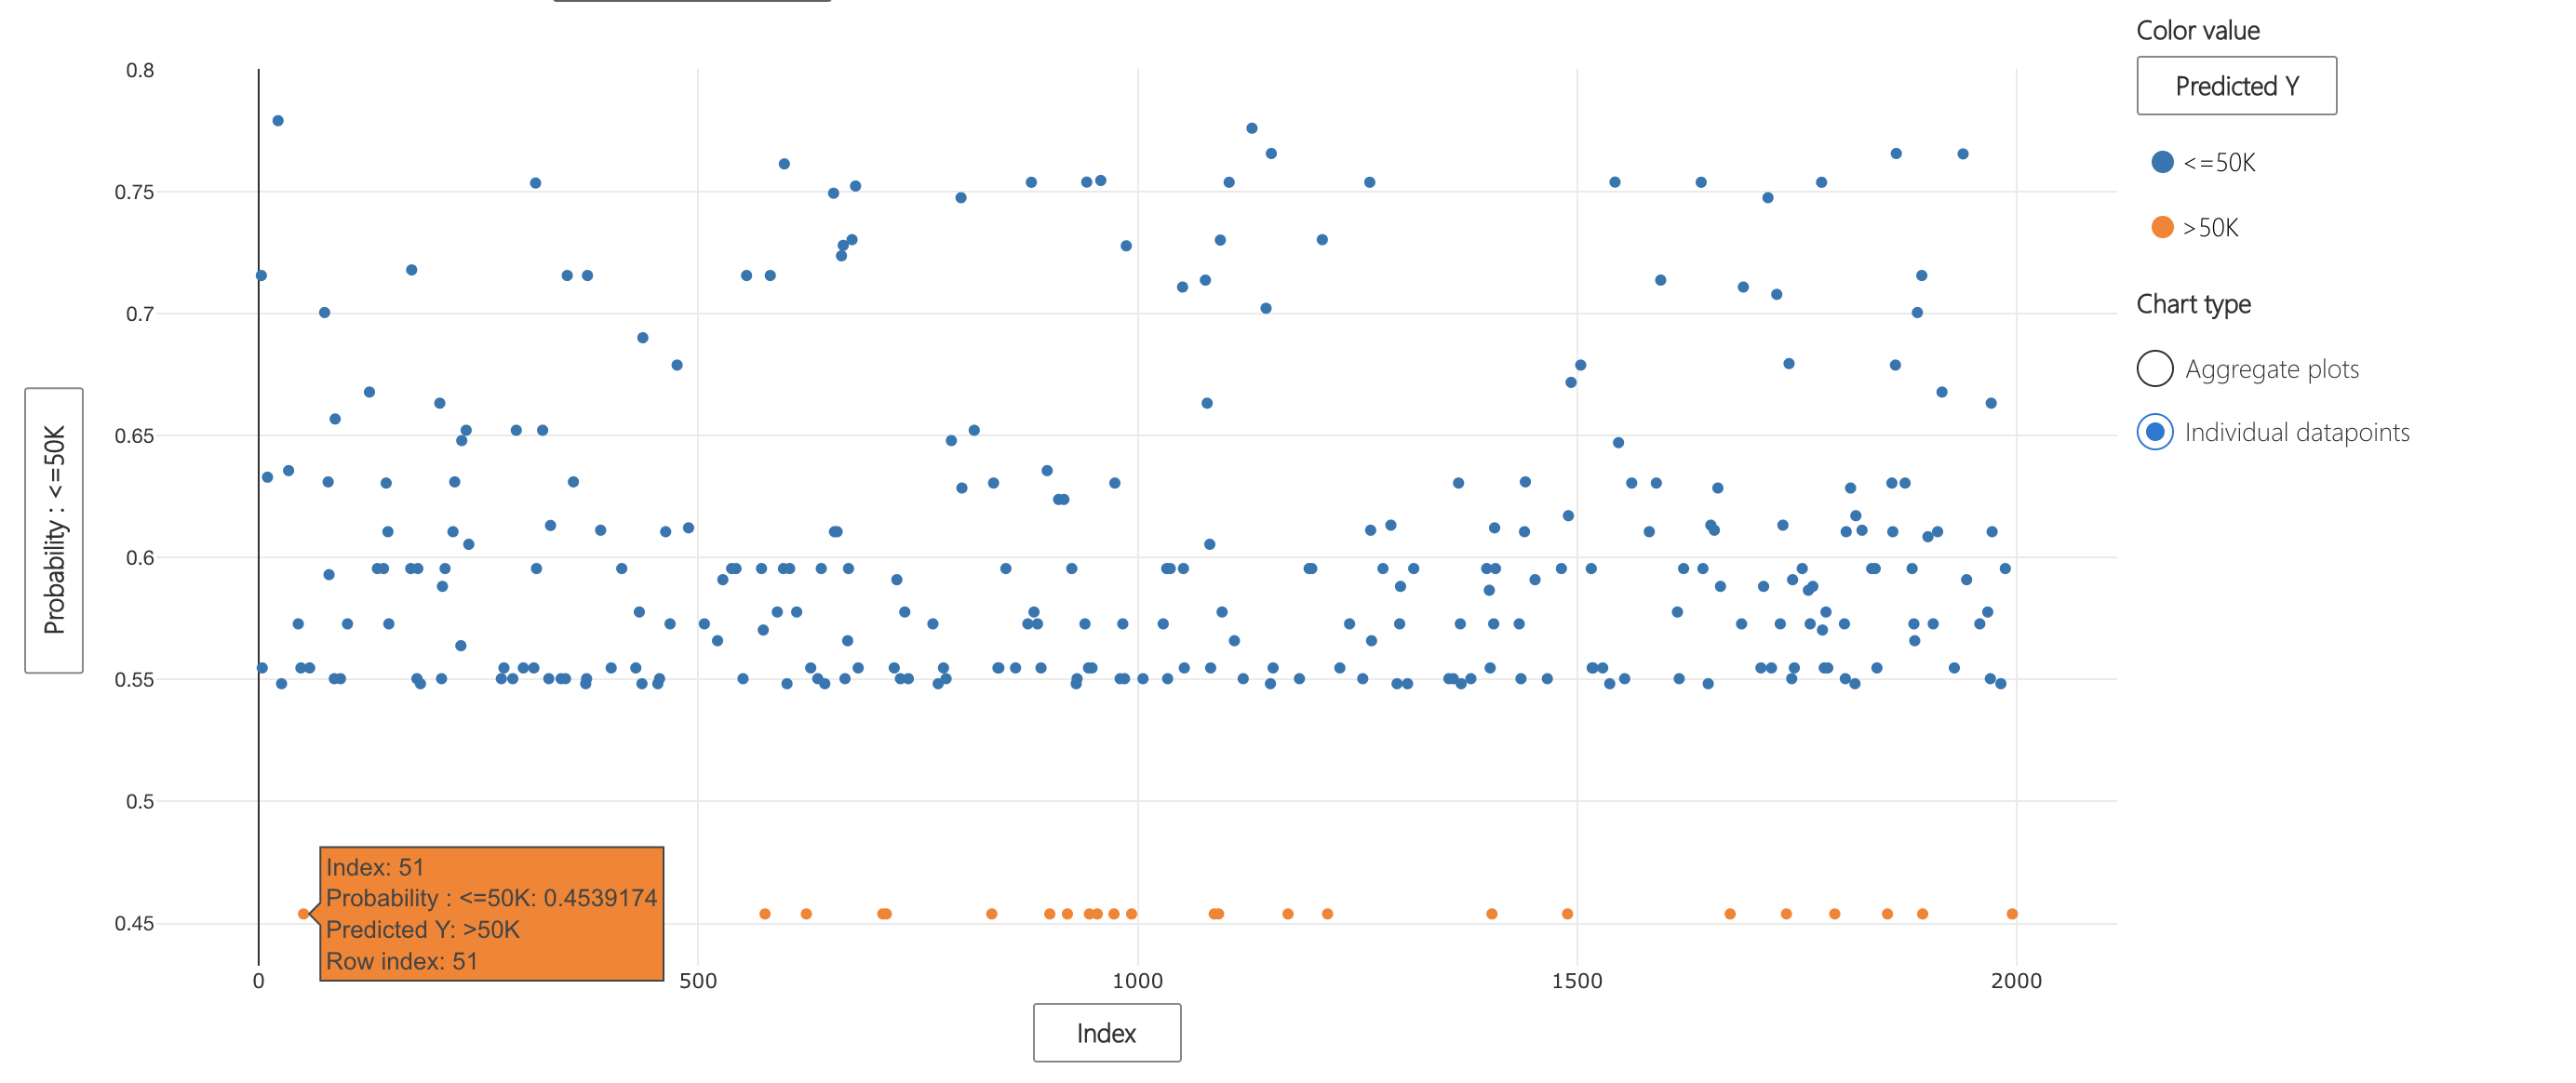

What factors led the model to make this decision?

The "Individual feature importance" tab in the Interpretability component's Feature Importances section let you select points for further analysis.

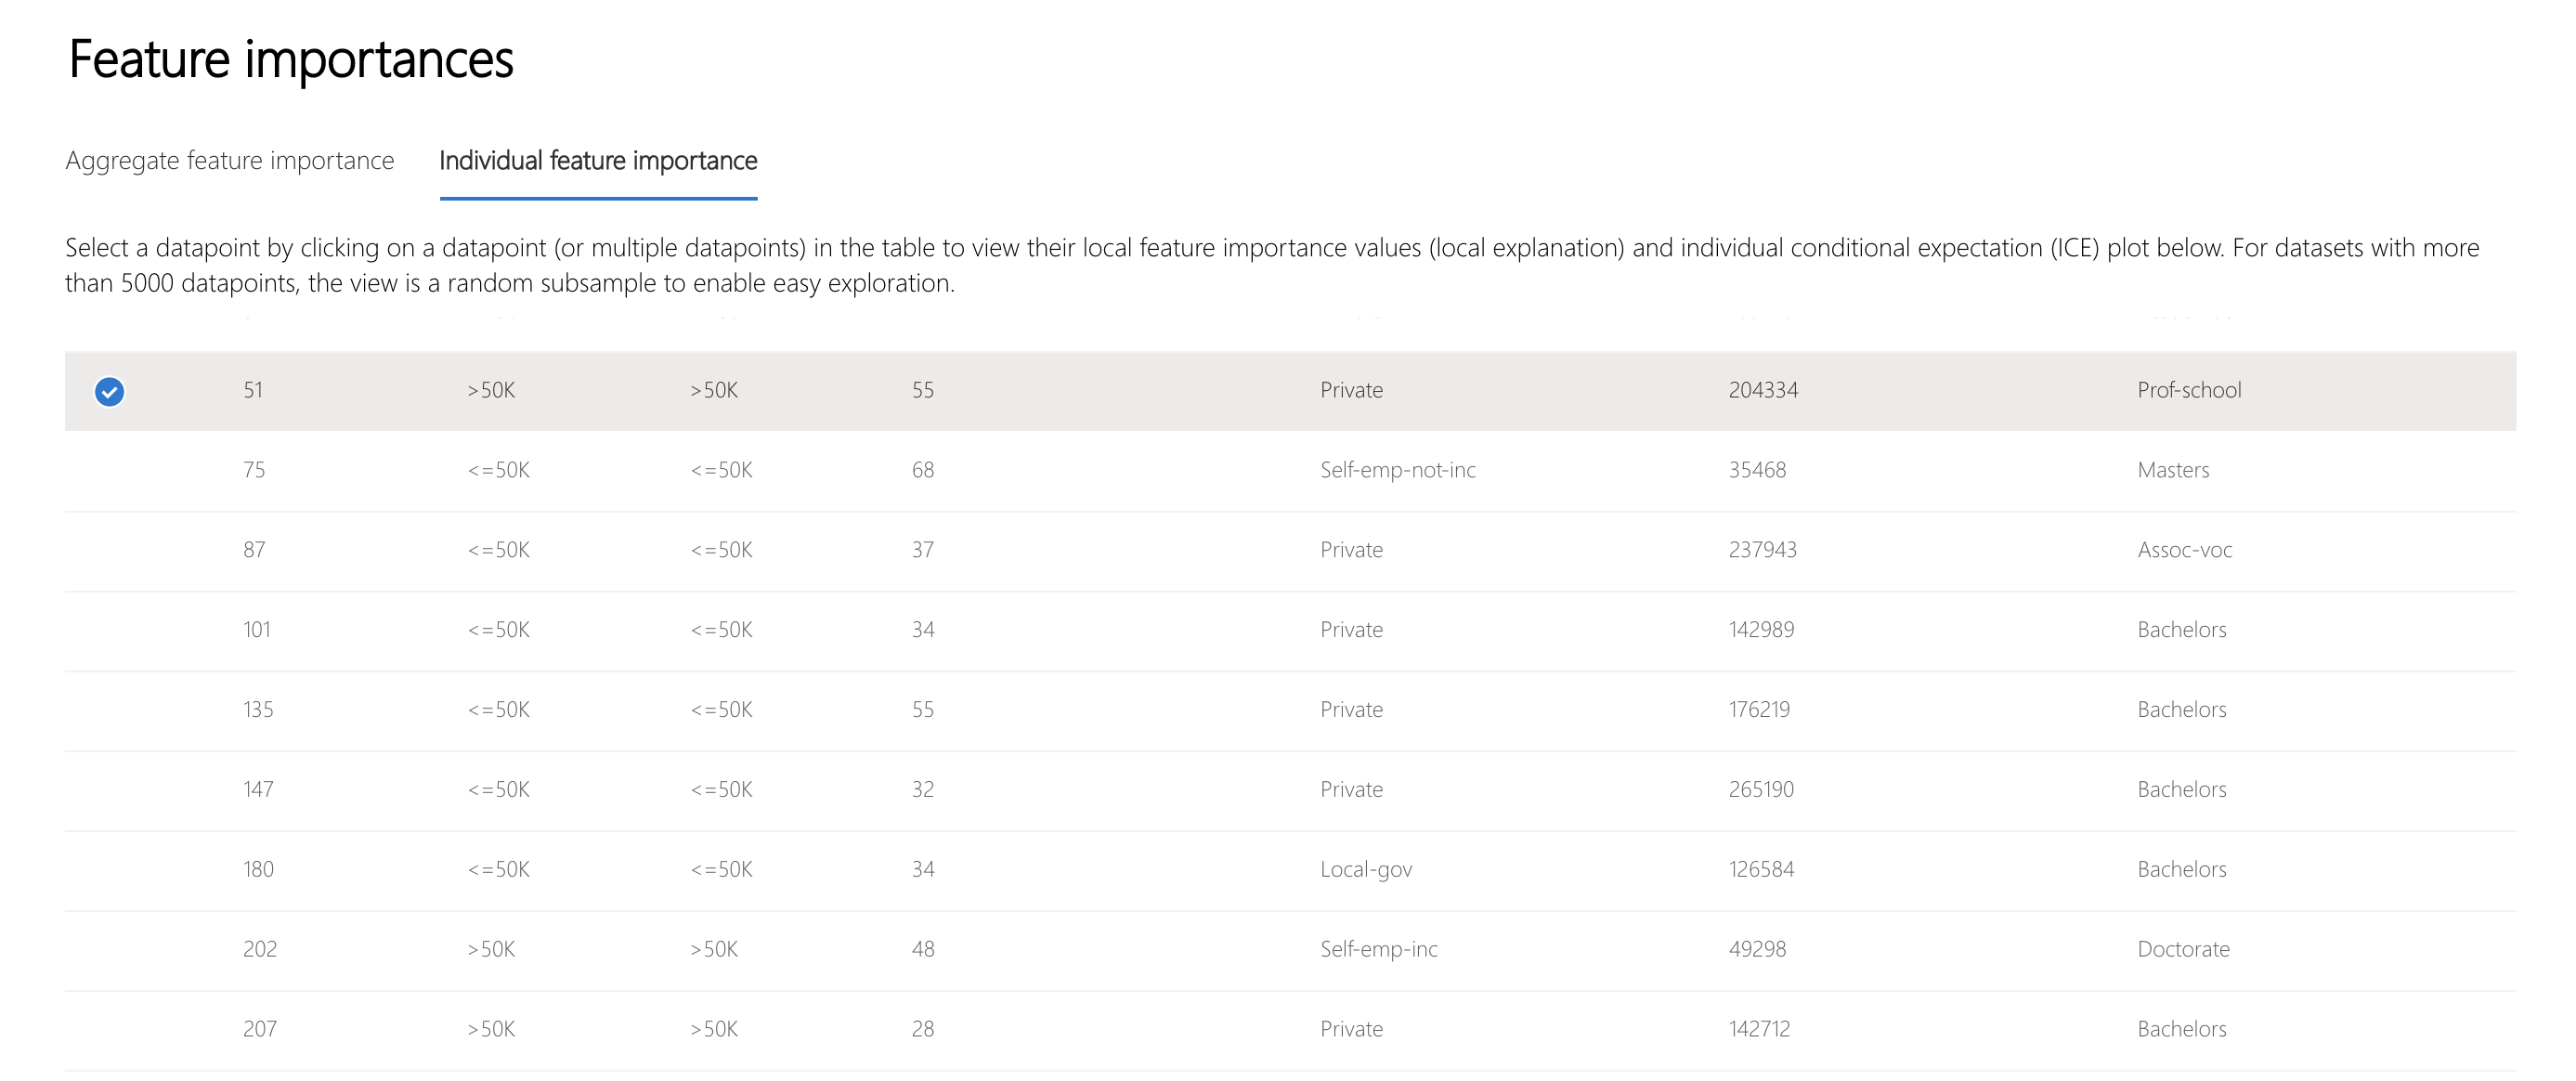

Under this, the feature importance plot shows `capital-gain` and `native-country` as the most significant factors leading to the <= 50K classification. Changing these may cause the threshold to be crossed and the model to predict the opposite class. Please note that depending on the context, the high importance of `native-country` might be considered as a fairness issue.

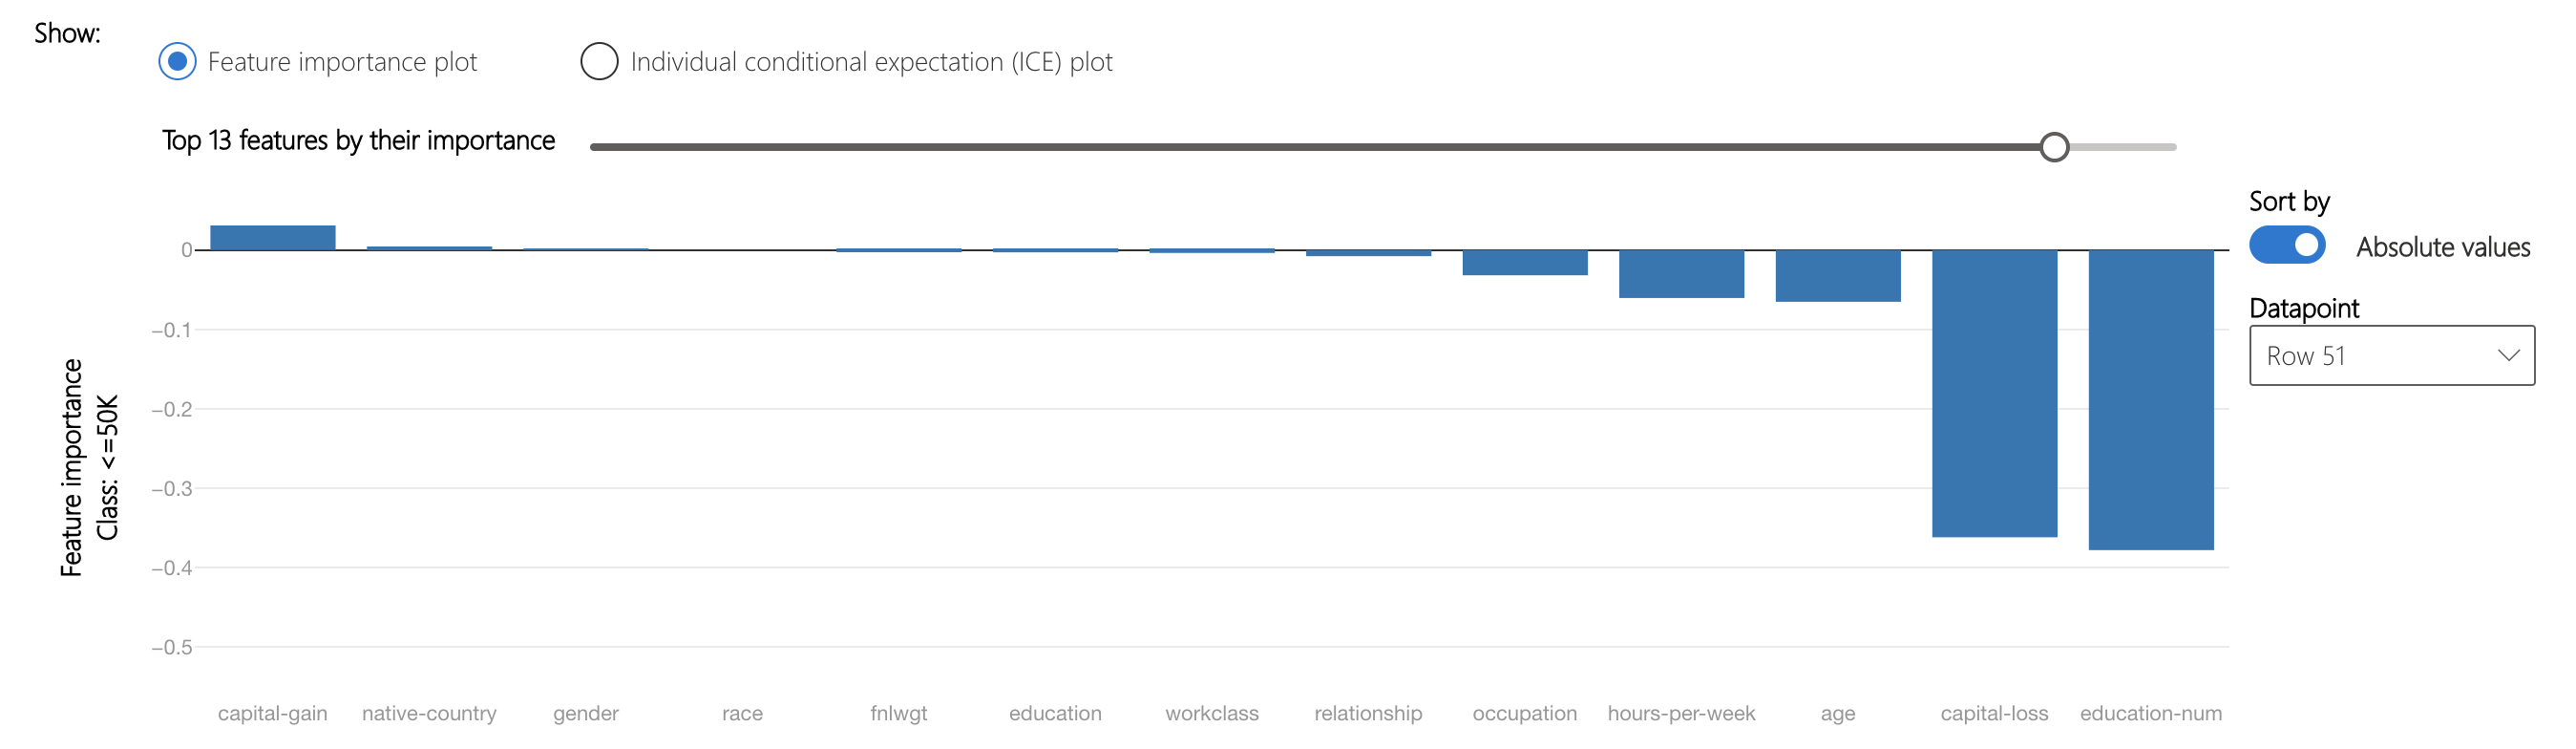

The What-If Counterfactuals component focuses on how to change features slightly in order to change model predictions. As seen in its top ranked features bar plot, changing this person's marital-status, capital-loss, and education-num have the highest impact on flipping the prediction to > 50K.

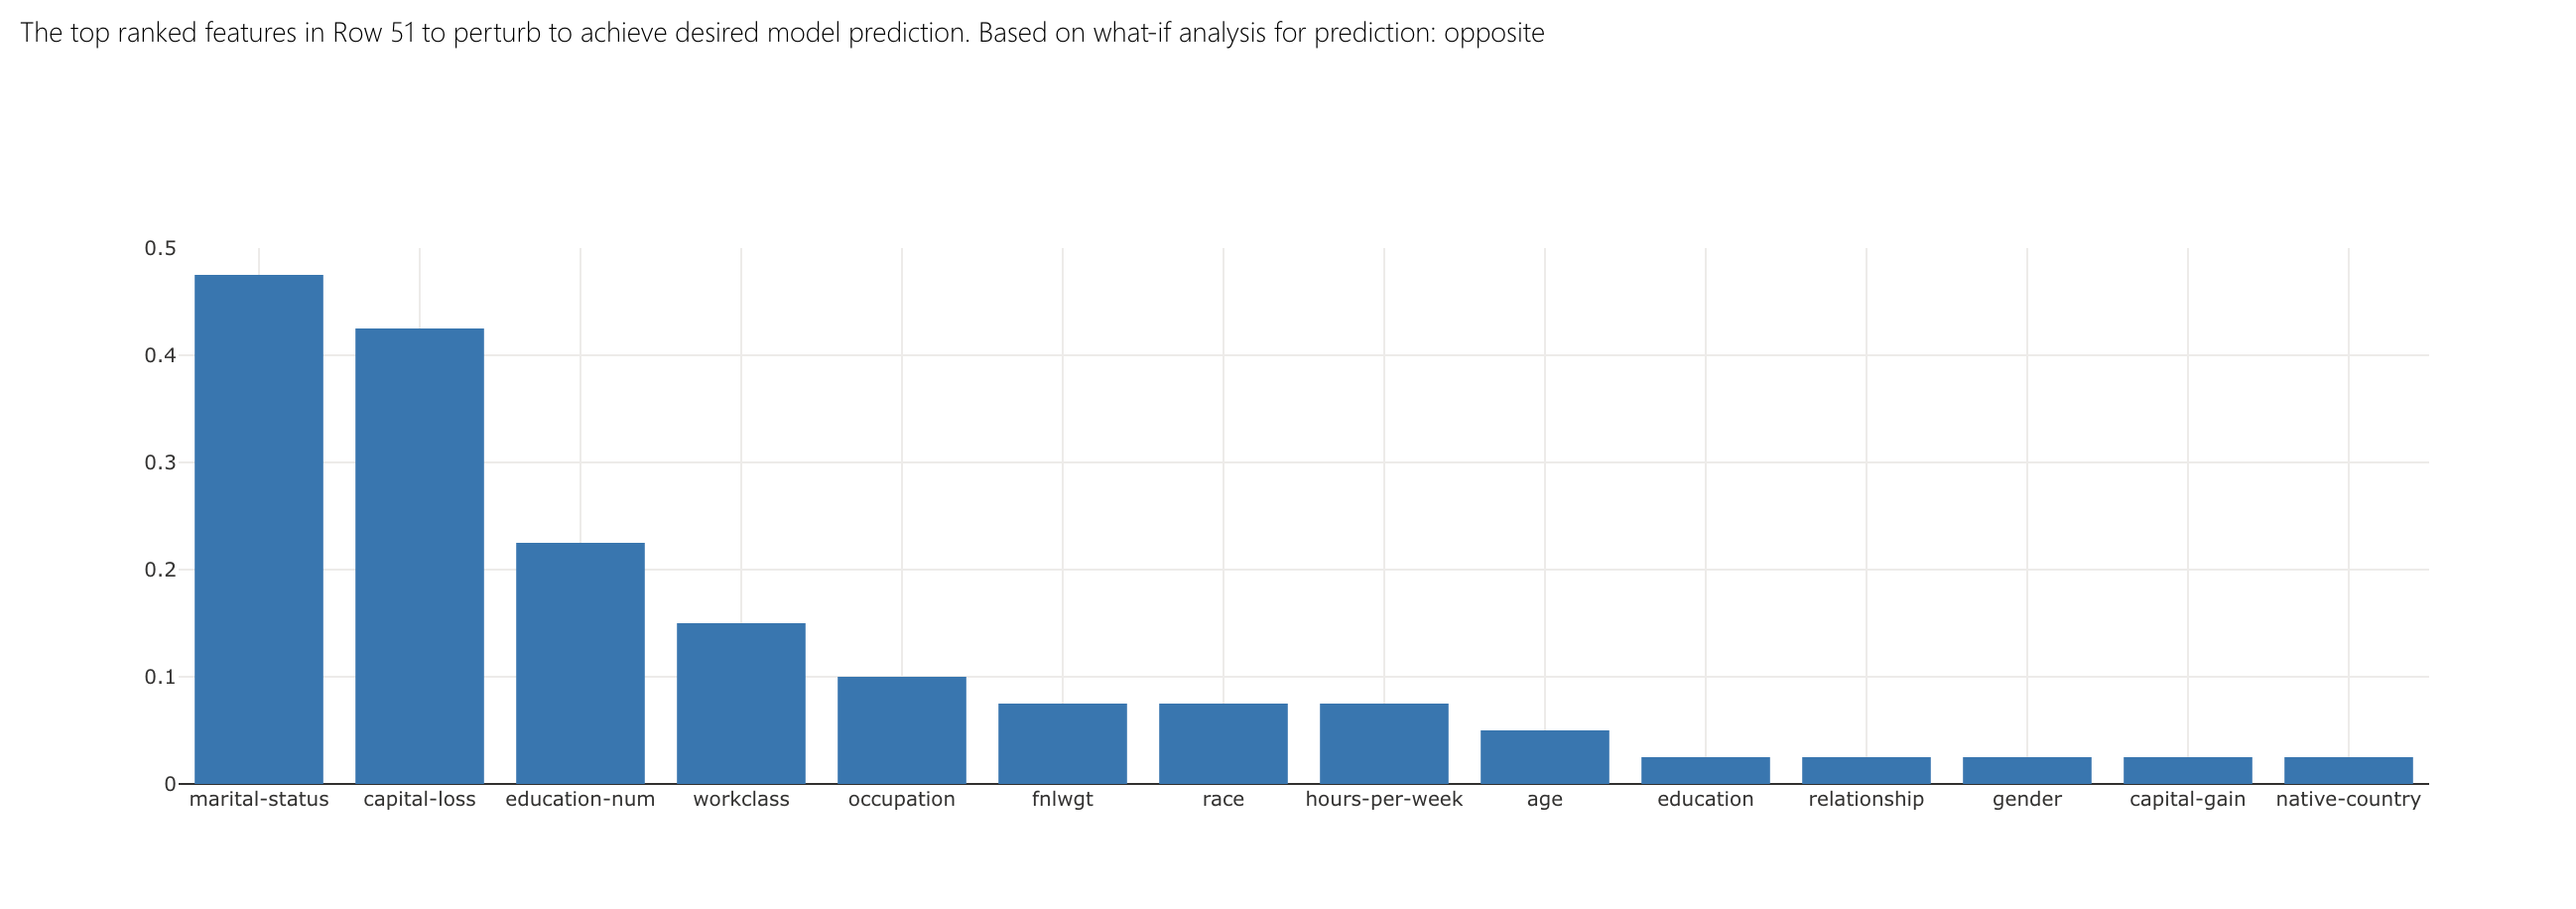